We want to use (train) a Gaussian Process for regression analysis so that we can determin (by fitting) 

In [1]:
using CSV
using DataFrames
using PyPlot
using StatsBase
# using Random
# using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"
# using Printf

using ScikitLearn # machine learning package
using ScikitLearn.CrossValidation: train_test_split
@sk_import gaussian_process : GaussianProcessRegressor
@sk_import gaussian_process.kernels : Matern

@sk_import inspection : permutation_importance
# @sk_import metrics : confusion_matrix

PyObject <function permutation_importance at 0x7f3b259da8c8>

In [2]:
filename = joinpath(pwd(), "descriptors/cof_descriptors.csv")
descriptors = CSV.read(filename, DataFrame)

filename = joinpath(pwd(), "henry_calculations.csv")
henry_data = CSV.read(filename, DataFrame)

# for some reason these ones aren't working... LOOk INTO IT
skip_for_now = ["07012N3_ddec.cif", "16290N3_ddec.cif", "21111N3_ddec.cif"]
delete!(descriptors, findfirst(descriptors[:, "crystal_name"] .== skip_for_now[1]))

dataset = outerjoin(henry_data, descriptors, on=["crystal_name"])
first(dataset, 5)

,crystal_name,H_Xe,err_H_Xe,time_Xe,H_Kr,err_H_Kr,time_Kr
,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,05000N2_ddec.cif,0.539934,0.0579636,1.65142,0.341621,0.0214178,1.80109
2,05001N2_ddec.cif,1.12541,0.00422026,5.29136,0.344019,0.00165314,5.61557
3,07000N2_ddec.cif,1.07055,0.00303046,4.24425,0.357101,0.00161386,4.40649
4,07001N2_ddec.cif,10.7021,0.112161,1.73891,1.18731,0.012399,1.84388
5,07002N2_ddec.cif,1.35961,0.00542812,3.27022,0.377404,0.00248071,3.25362


In [3]:
names(dataset)

23-element Vector{String}:
 "crystal_name"
 "H_Xe"
 "err_H_Xe"
 "time_Xe"
 "H_Kr"
 "err_H_Kr"
 "time_Kr"
 "selectivity"
 "selectivity_err"
 "pore_diameter_Å"
 "void_fraction"
 "surface_area_m²g⁻¹"
 "crystal_density"
 "density_of_Carbon"
 "density_of_Hydrogen"
 "density_of_Oxygen"
 "density_of_Nitrogen"
 "density_of_Silicon"
 "density_of_Sulfur"
 "density_of_Boron"
 "density_of_Phosphorus"
 "density_of_Halogens"
 "density_of_Metals"

Scikitlearn takes as input:

- a feature matrix X, which must be n_samples by n_features
- a target vector y, which must be n_samples long (of course)

In [4]:
# x_cols = [name for name in names(descriptors) if name != "crystal_name"]
x_cols = ["pore_diameter_Å", "surface_area_m²g⁻¹", "density_of_Oxygen", "density_of_Carbon"]
n_xtals = nrow(dataset)

X = zeros(n_xtals, length(x_cols))
y = zeros(n_xtals)

for (i, row) in enumerate(eachrow(dataset))
    [X[i, j] = row[col] for (j, col) in enumerate(x_cols)]
    y[i] = row["selectivity"]
end
X # look at y too!

611×4 Matrix{Float64}:
  3.84928  4175.64  0.00974344  0.0292303
 19.7302   3156.96  0.00455128  0.0204808
 26.1625   3407.23  0.00285873  0.0171524
  7.82083  2565.59  0.00933726  0.037349
 14.8469   3345.75  0.00388437  0.0271906
  9.33026  5261.66  0.00239773  0.0149858
  9.94867  5452.36  0.00209882  0.0125929
 27.193    5190.06  0.00105132  0.00643935
 10.0414   5593.85  0.00350446  0.0156241
  4.7838   3845.42  0.00936888  0.0374755
  7.51918  3597.55  0.0089547   0.0313415
  9.8332   3440.67  0.00886007  0.0265802
 13.0805   3172.89  0.00868189  0.0217047
  ⋮                             
  4.50341  4381.85  0.00146848  0.0447887
  8.19356  4970.28  0.0         0.0324251
 33.8692   3512.34  0.00137541  0.0119202
 24.4929   4424.18  0.0         0.0170632
 23.3063   5319.46  0.0         0.0140848
 22.3437   4252.1   0.0         0.0197639
 25.838    3967.32  0.0         0.0189314
 44.2216   5030.4   0.0         0.0108662
 44.8273   4807.29  0.0         0.011215
 29.8214   4961.92  0

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25);

In [6]:
# train on training data
kernel = Matern(nu=2.5, length_scale=0.25)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=true)
gpr.fit(X_train, y_train)

# get predictions on test data
y_pred = gpr.predict(X_test)

153-element Vector{Float64}:
 4.308851165516869
 4.181289210142494
 3.8437716617067896
 4.005756500313067
 4.226699127853885
 4.25070348596347
 4.249040447013463
 4.281895755692071
 4.286878167326135
 4.281380550635115
 4.345978556676721
 3.764363895453479
 4.241004374800348
 ⋮
 4.266234065079551
 4.225165339127493
 3.9744698374958918
 4.518465060303483
 4.242965584345097
 4.282824429059085
 4.393816839743056
 4.2828767231767895
 4.227244360346306
 3.599734629923035
 4.280582312492599
 4.049933172469172

In [7]:
# compute RMSE, R2 on test data
rmse = sqrt(mean((y_test - y_pred).^2))
r2 = gpr.score(X_test, y_test)

0.10667733600268303

In [8]:
# permutation importance
feature_importances = permutation_importance(gpr, X_test, y_test)

Dict{Any, Any} with 3 entries:
  "importances_std"  => [0.232669, 0.0899059, 4.43058e-8, 5.40969e-7]
  "importances_mean" => [0.33469, 0.177055, 3.30975e-8, 1.44382e-6]
  "importances"      => [0.781487 0.332502 … 0.149503 0.165629; 0.267183 0.2013…

## Parity Plot

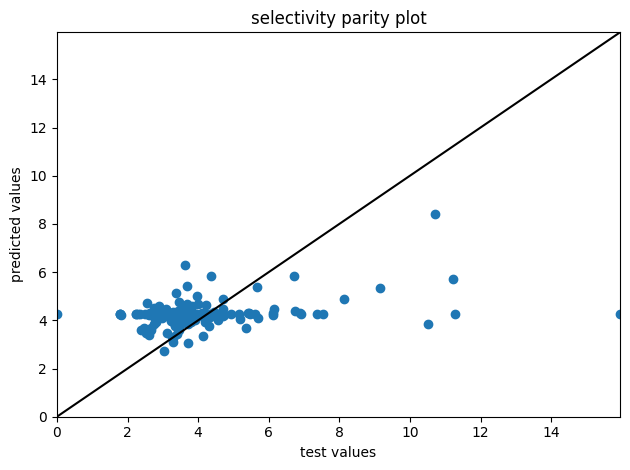

In [9]:
figure()

xmax = maximum(max.(y_test, y_pred))
x = range(0.0, stop=xmax, length=length(y_test))
y = x
plot(x, y, color="k")

scatter(y_test, y_pred)

xlim([0.0, xmax])
ylim([0.0, xmax])

title("selectivity parity plot")
xlabel("test values")
ylabel("predicted values")

tight_layout()